In [5]:
import pandas as pd
import json
import numpy as np
import operator
import matplotlib.pyplot as plt
from collections import Counter
import os
import time
import pickle
import networkx as nx
import string

pd.options.mode.chained_assignment = None  # default='warn'

ROOT = os.path.dirname(os.getcwd())
teams = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'teams.pkl.gz'))
players = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'players.pkl.gz'))
players['shortName'] = players['shortName'].apply(lambda s: ''.join([x for x in s if x.isalpha() or x in [' ', '.'] ]))
player_mapping = {row['wyId'] : row['shortName'] for i, row in players.iterrows()}
players

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea.id,passportArea.alpha3code,passportArea.alpha2code,role.code2,role.code3,role.name,birthArea.name,birthArea.id,birthArea.alpha3code,birthArea.alpha2code
0,78,Harun,,Tekin,4502,1989-06-17,187,32777,right,H. Tekin,...,792,TUR,TR,GK,GKP,Goalkeeper,Turkey,792,TUR,TR
1,73,Malang,,Sarr,3775,1999-01-23,182,393228,left,M. Sarr,...,686,SEN,SN,DF,DEF,Defender,France,250,FRA,FR
2,72,Over,,Mandanda,3772,1998-10-26,176,393230,,O. Mandanda,...,250,FRA,FR,GK,GKP,Goalkeeper,France,250,FRA,FR
3,82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,32793,right,A. NDiaye,...,686,SEN,SN,MD,MID,Midfielder,France,250,FRA,FR
4,84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,393247,right,I. Konatue,...,250,FRA,FR,DF,DEF,Defender,France,250,FRA,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,72,Ali,,Ma\u00e2loul,16041,1990-01-01,175,120839,left,A. Maueloul,...,788,TUN,TN,DF,DEF,Defender,Tunisia,788,TUN,TN
3599,76,Carlos Alberto,,C\u00e1ceda Oyaguez,15591,1991-09-27,183,114736,right,C. Cueceda,...,604,PER,PE,GK,GKP,Goalkeeper,Peru,604,PER,PE
3600,78,Miguel Gianpierre,,Araujo Blanco,12072,1994-10-24,179,114908,right,M. Araujo,...,604,PER,PE,DF,DEF,Defender,Peru,604,PER,PE
3601,70,Ahmed Reda,,Tagnaouti,16183,1996-04-05,182,285583,right,A. Tagnaouti,...,504,MAR,MA,GK,GKP,Goalkeeper,Morocco,504,MAR,MA


# Background:
We have already found a high correlation between team teh average number of passes by a team / game with performance (proxied through end of season points, goals scored, and shots taken)

Now we wish to take a deeper look at the passing profile at a per-game basis. Essentially we are constructing the building blocks of the H-statistic as done by Pappalardo et. al.

# H Statistic Building Blocks Reconstruction

## Per game passing volume (w)

In [6]:
events = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'events_df.pkl.gz'))
events_passing = events.loc[events['eventName']=='Pass']
events_passing.head(5)

eventId subEventName            tags  playerId  \
Italy 0         8  Simple pass  [{'id': 1801}]      8327   
      1         8  Simple pass  [{'id': 1801}]     20438   
      5         8  Simple pass  [{'id': 1801}]      8306   
      10        8  Simple pass  [{'id': 1801}]     86366   
      14        8  Simple pass  [{'id': 1801}]      8306   

                                         positions  matchId eventName  teamId  \
Italy 0   [{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]  2575959      Pass    3158   
      1   [{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]  2575959      Pass    3158   
      5   [{'y': 15, 'x': 72}, {'y': 25, 'x': 72}]  2575959      Pass    3158   
      10  [{'y': 82, 'x': 38}, {'y': 88, 'x': 43}]  2575959      Pass    3172   
      14  [{'y': 15, 'x': 61}, {'y': 15, 'x': 37}]  2575959      Pass    3158   

         matchPeriod   eventSec subEventId         id  
Italy 0           1H   2.530536         85  180423957  
      1           1H   3.768418         85  180423958  
      5           1H  10.376066         85  180423962  
      10          1H  16.240563         85  180423979  
      14          1H  19.153235         85  180423968

In [7]:
w = events_passing.groupby(['matchId', 'teamId']).count().mean(axis=1).to_frame('w').sort_index() #Dont really need the mean, all cols are the same anyways
w.head()

w
matchId teamId       
2499719 1609    606.0
        1631    230.0
2499720 1625    754.0
        1651    184.0
2499721 1610    516.0

## Passing profile amoungst players each game

Here we analyze the mean number of passes managed by each player during a game. For this distribution we are interested in finding the mean and variance.

### First Lets Try Making Passing Networks
**Naive Assumption:** A pass X from player i is to player j if player j initiates the next recorded pass after X. This may be violated for turnovers, fouls, and out-of-play stoppages.

The network is such that each plaer is a node, and directed edges from node i to node j are proportional in magnitude to the passing frequency from player i to player j

In [8]:
matchId = 2499939

#Get the time for the latest event in the first half for this match
end_first_half = events.loc[(events['matchId']==matchId)
                            &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


df = events_passing.loc[(events_passing['matchId']==matchId)]
df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
df = df[['playerId', 'positions', 'teamId', 'time']]


team1, team2 = df['teamId'].unique()
profile_team1 = df.loc[df['teamId'] == team1, ['playerId', 'time']].sort_values(by='time').reset_index(drop=True)
profile_team2 = df.loc[df['teamId'] == team2, ['playerId', 'time']].sort_values(by='time').reset_index(drop=True)


#Filter to players that have played at least 50 minutes of football to reduce outlier effects
player_time = (profile_team1.groupby('playerId').max() - profile_team1.groupby('playerId').min())
#relevant_players = player_time.loc[player_time['time']>3000].index
#profile_team1 = profile_team1.loc[profile_team1['playerId'].isin(relevant_players)]

player_time = (profile_team2.groupby('playerId').max() - profile_team2.groupby('playerId').min())
#relevant_players = player_time.loc[player_time['time']>3000].index
#profile_team2 = profile_team2.loc[profile_team2['playerId'].isin(relevant_players)]



# Naive assumption: Receiver is the player who made the next pass in this team - doesn't account for interceptions
# We will make a graph with edge (i, j) value = Number of passes from player i to player j
profile_team1['sender'] = profile_team1['playerId']
profile_team1['receiver'] = profile_team1['playerId'].shift(-1).dropna()
profile_team1 = profile_team1[['sender', 'receiver']]
profile_team1 = profile_team1.loc[profile_team1['sender'] != profile_team1['receiver']]
profile_team1 = profile_team1.groupby(['sender','receiver']).size().to_frame('weight').reset_index().astype(int)

profile_team2['sender'] = profile_team2['playerId']
profile_team2['receiver'] = profile_team2['playerId'].shift(-1).dropna()
profile_team2 = profile_team2[['sender', 'receiver']]
profile_team2 = profile_team2.loc[profile_team2['sender'] != profile_team2['receiver']]
profile_team2 = profile_team2.groupby(['sender','receiver']).size().to_frame('weight').reset_index().astype(int)


### Vizualization

Arsenal
density = 0.7756410256410257


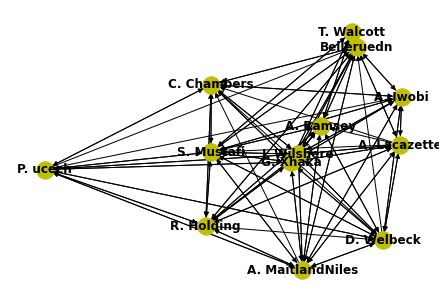

Arsenal: mean = 0.8264462809917356 ; std = 0.6192236823542223 ; count = 493




AFC Bournemouth
density = 0.6318681318681318


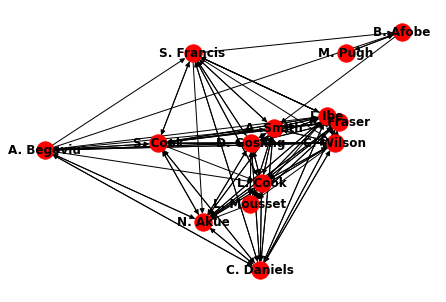

AFC Bournemouth: mean = 0.8695652173913043 ; std = 0.5674027506955998 ; count = 315


In [9]:
#Avg position/player
player_positions = events.loc[(events['matchId']==matchId)]
player_positions['x'] = player_positions['positions'].apply(lambda l: l[0]['x'])
player_positions['y'] = player_positions['positions'].apply(lambda l: l[0]['y'])
player_positions = player_positions[['x', 'y', 'playerId']].groupby(df['playerId'])[['x', 'y']].mean()
player_positions = player_positions.join(pd.Series(player_mapping, name='name'))

positions1 = player_positions.loc[player_positions.index.isin(profile_team1['sender'].unique())]
positions1 = {row['name'] : (row['x'], row['y']) for i, row in positions1.iterrows()}

positions2 = player_positions.loc[player_positions.index.isin(profile_team2['sender'].unique())]
positions2 = {row['name'] : (row['x'], row['y']) for i, row in positions2.iterrows()}


#team and player names
team1, team2 = teams.loc[teams['wyId']==team1,'name'].values[0], teams.loc[teams['wyId']==team2,'name'].values[0]

g = nx.DiGraph()
g.add_edges_from([(row['sender'], row['receiver'], {'weight':row['weight']}) for i, row in profile_team1.iterrows()])
g = nx.relabel_nodes(g, player_mapping)
nx.draw(g, positions1, with_labels=True, font_weight='bold', node_color = 'y')
print (team1)
#print ('centrality =', nx.global_reaching_centrality(g))
#print ('algebric connectivity =', nx.algebraic_connectivity(g))
print ('density =', nx.density(g))
plt.show()
print ('%s: mean ='%team1, profile_team1['weight'].mean()/profile_team1['weight'].sum()*100,
       '; std =', profile_team1['weight'].std()/profile_team1['weight'].sum()*100,
       '; count =', profile_team1['weight'].sum())

print('\n\n\n')

g = nx.DiGraph()
g.add_edges_from([(row['sender'], row['receiver'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
g = nx.relabel_nodes(g, player_mapping)
nx.draw(g, positions2, with_labels=True, font_weight='bold', node_color='r')
print (team2)
#print ('centrality =', nx.global_reaching_centrality(g))
#print ('algebric connectivity =', nx.algebraic_connectivity(g))
print ('density =', nx.density(g))
plt.show()
print ('%s: mean ='%team2, profile_team2['weight'].mean()/profile_team2['weight'].sum()*100,
       '; std =', profile_team2['weight'].std()/profile_team2['weight'].sum()*100,
       '; count =', profile_team2['weight'].sum())

## What can we even get from these graphs?

Mean and Standard Deviation of the # of passes players have been involved in

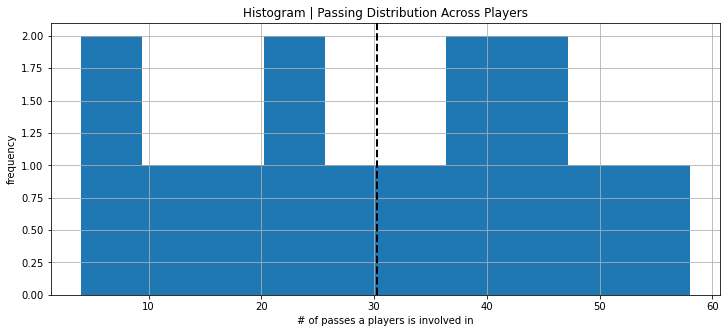

In [25]:
df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
df.hist(figsize = (12, 5))
plt.axvline(df.mean(), color='k', linestyle='dashed', linewidth=2)
plt.xlabel('# of passes a players is involved in')
plt.ylabel('frequency')
plt.title('Histogram | Passing Distribution Across Players')
plt.show()

In [18]:
df

M. Albrighton    38
K. Schmeichel    25
W. Morgan        34
H. Maguire       41
J. Vardy         18
S. Okazaki       24
C. Fuchs         58
R. Mahrez        48
D. Simpson       46
W. Ndidi         42
M. James         30
D. Amartey       10
D. Gray           6
K. Iheanacho      4
Name: number_passes_invloved, dtype: int64

There's definitely more that can be done with these graphs - will explore more later

# Streamlining the process

In [252]:
matches = w.index.get_level_values(0).unique(); n=len(matches)
network_stats = dict()



for i, match in enumerate(matches):
    if i % 50 == 0: print('{}/{}'.format(i, n))
    
    matchId = match

    #Get the time for the latest event in the first half for this match
    end_first_half = events.loc[(events['matchId']==matchId)
                                &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


    df = events_passing.loc[(events_passing['matchId']==matchId)]
    df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
    df = df[['playerId', 'positions', 'teamId', 'time']]


    team1, team2 = df['teamId'].unique()
    profile_team1 = df.loc[df['teamId'] == team1, ['playerId', 'time']].sort_values(by='time').reset_index(drop=True)
    profile_team2 = df.loc[df['teamId'] == team2, ['playerId', 'time']].sort_values(by='time').reset_index(drop=True)
    
    #Saving Stats as dict of dicts
    network_stats[match] = dict()
    network_stats[match][team1], network_stats[match][team2] = dict(), dict() 


    #Filter to players that have played at least 50 minutes of football to reduce outlier effects
    player_time = (profile_team1.groupby('playerId').max() - profile_team1.groupby('playerId').min())
    #relevant_players = player_time.loc[player_time['time']>3000].index
    #profile_team1 = profile_team1.loc[profile_team1['playerId'].isin(relevant_players)]

    player_time = (profile_team2.groupby('playerId').max() - profile_team2.groupby('playerId').min())
    #relevant_players = player_time.loc[player_time['time']>3000].index
    #profile_team2 = profile_team2.loc[profile_team2['playerId'].isin(relevant_players)]



    # Naive assumption: Receiver is the player who made the next pass in this team - doesn't account for interceptions
    # We will make a graph with edge (i, j) value = Number of passes from player i to player j
    profile_team1['sender'] = profile_team1['playerId']
    profile_team1['receiver'] = profile_team1['playerId'].shift(-1).dropna()
    profile_team1 = profile_team1[['sender', 'receiver']]
    profile_team1 = profile_team1.loc[profile_team1['sender'] != profile_team1['receiver']]
    profile_team1 = profile_team1.groupby(['sender','receiver']).size().to_frame('weight').reset_index().astype(int)

    profile_team2['sender'] = profile_team2['playerId']
    profile_team2['receiver'] = profile_team2['playerId'].shift(-1).dropna()
    profile_team2 = profile_team2[['sender', 'receiver']]
    profile_team2 = profile_team2.loc[profile_team2['sender'] != profile_team2['receiver']]
    profile_team2 = profile_team2.groupby(['sender','receiver']).size().to_frame('weight').reset_index().astype(int)

    g = nx.DiGraph()
    g.add_edges_from([(row['sender'], row['receiver'], {'weight':row['weight']}) for i, row in profile_team1.iterrows()])
    df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
    network_stats[match][team1]['mean_passes_players'] = df.mean()
    network_stats[match][team1]['std_passes_players'] = df.std()
    
    g = nx.DiGraph()
    g.add_edges_from([(row['sender'], row['receiver'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
    df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
    network_stats[match][team2]['mean_passes_players'] = df.mean()
    network_stats[match][team2]['std_passes_players'] = df.std()
    
    

0/1826
50/1826
100/1826
150/1826
200/1826
250/1826
300/1826
350/1826
400/1826
450/1826
500/1826
550/1826
600/1826
650/1826
700/1826
750/1826
800/1826
850/1826
900/1826
950/1826
1000/1826
1050/1826
1100/1826
1150/1826
1200/1826
1250/1826
1300/1826
1350/1826
1400/1826
1450/1826
1500/1826
1550/1826
1600/1826
1650/1826
1700/1826
1750/1826
1800/1826


In [253]:
network_stats = pd.DataFrame.from_dict({(i,j): network_stats[i][j] 
                           for i in network_stats.keys() 
                           for j in network_stats[i].keys()},
                       orient='index')
network_stats

mean_passes_players  std_passes_players
2499719 1609            84.285714           59.311989
        1631            30.285714           16.559583
2499720 1625           105.428571           73.886310
        1651            24.428571           14.345808
2499721 1646            43.692308           25.975580
...                           ...                 ...
2576336 3158            68.428571           39.144141
2576337 3164            66.615385           39.434626
        3204            53.538462           23.564151
2576338 3193            73.714286           35.497407
        3185            46.571429           18.756391

[3652 rows x 2 columns]

# Combining the Metrics and Results

In [46]:
#df = pd.concat([w, network_stats], axis=1)
#df.to_pickle(os.path.join(ROOT, 'intermediates', 'player_passing_networks_exploration.pkl.gz'))
df = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_passing_networks_exploration.pkl.gz'))
df

w  mean_passes_players  std_passes_players
2499719 1609  606.0            84.285714           59.311989
        1631  230.0            30.285714           16.559583
2499720 1625  754.0           105.428571           73.886310
        1651  184.0            24.428571           14.345808
2499721 1610  516.0            77.230769           48.071395
...             ...                  ...                 ...
2576336 3315  337.0            46.571429           24.453140
2576337 3164  446.0            66.615385           39.434626
        3204  363.0            53.538462           23.564151
2576338 3185  338.0            46.571429           18.756391
        3193  532.0            73.714286           35.497407

[3652 rows x 3 columns]

In [47]:
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))

df['mean_passes_players_norm'] = df['mean_passes_players']/df['w']
df['std_passes_players_norm'] = df['std_passes_players']/df['w']
df = df.drop(columns=['mean_passes_players', 'std_passes_players'])
df = df.mean(level=1).sort_index()



#display(df.corr())
df = pd.concat([df, performance], axis=1)

,w,mean_passes_players_norm,std_passes_players_norm,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
w,1.000000,0.217785,0.589938,1.000000,0.803065,0.812468,0.763279
mean_passes_players_norm,0.217785,1.000000,0.117718,0.217785,0.153953,0.187259,0.186572
std_passes_players_norm,0.589938,0.117718,1.000000,0.589938,0.434198,0.427707,0.502012
avg_pass_per_game,1.000000,0.217785,0.589938,1.000000,0.803065,0.812468,0.763279
avg_shots_per_game,0.803065,0.153953,0.434198,0.803065,1.000000,0.774971,0.719890
avg_goals_per_game,0.812468,0.187259,0.427707,0.812468,0.774971,1.000000,0.873299
end_of_season_pts,0.763279,0.186572,0.502012,0.763279,0.719890,0.873299,1.000000


# Visualization

<Figure size 1080x360 with 0 Axes>

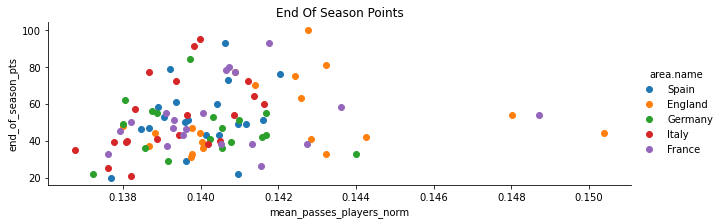

<Figure size 1080x360 with 0 Axes>

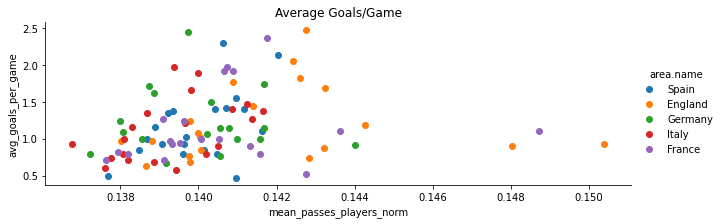

<Figure size 1080x360 with 0 Axes>

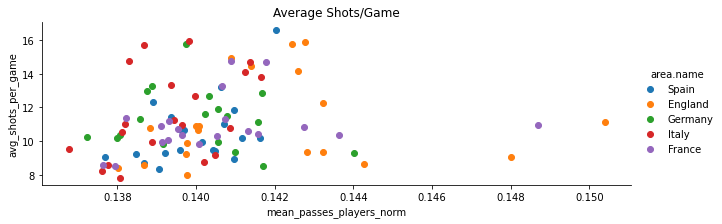

In [54]:
import seaborn
from matplotlib import pyplot 
#from ggplot import *

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'mean_passes_players_norm', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points')
plt.savefig('../figures/player_network/mean_vs_avg_pts_norm.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'mean_passes_players_norm', 'avg_goals_per_game').add_legend()
plt.title('Average Goals/Game')
plt.savefig('../figures/player_network/mean_vs_avg_goals_norm.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'mean_passes_players_norm', 'avg_shots_per_game').add_legend()
plt.title('Average Shots/Game')
plt.savefig('../figures/player_network/mean_vs_avg_shots_norm.png', bbox_inches='tight')
plt.show()

<Figure size 1080x360 with 0 Axes>

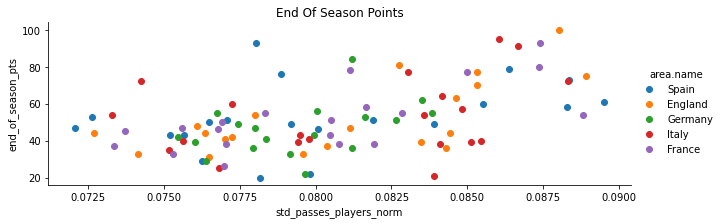

<Figure size 1080x360 with 0 Axes>

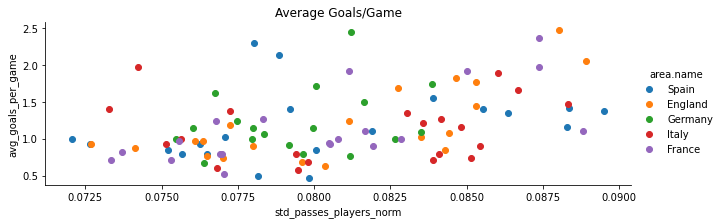

<Figure size 1080x360 with 0 Axes>

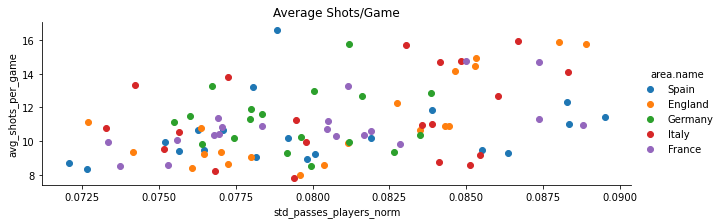

In [55]:
import seaborn
from matplotlib import pyplot 
#from ggplot import *

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'std_passes_players_norm', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points')
plt.savefig('../figures/player_network/std_vs_avg_pts_nrom.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'std_passes_players_norm', 'avg_goals_per_game').add_legend()
plt.title('Average Goals/Game')
plt.savefig('../figures/player_network/std_vs_avg_goals_nrom.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'std_passes_players_norm', 'avg_shots_per_game').add_legend()
plt.title('Average Shots/Game')
plt.savefig('../figures/player_network/std_vs_avg_shots_nrom.png', bbox_inches='tight')
plt.show()

In [62]:
df.corr()

,w,mean_passes_players_norm,std_passes_players_norm,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
w,1.000000,0.217785,0.589938,1.000000,0.803065,0.812468,0.763279
mean_passes_players_norm,0.217785,1.000000,0.117718,0.217785,0.153953,0.187259,0.186572
std_passes_players_norm,0.589938,0.117718,1.000000,0.589938,0.434198,0.427707,0.502012
avg_pass_per_game,1.000000,0.217785,0.589938,1.000000,0.803065,0.812468,0.763279
avg_shots_per_game,0.803065,0.153953,0.434198,0.803065,1.000000,0.774971,0.719890
avg_goals_per_game,0.812468,0.187259,0.427707,0.812468,0.774971,1.000000,0.873299
end_of_season_pts,0.763279,0.186572,0.502012,0.763279,0.719890,0.873299,1.000000


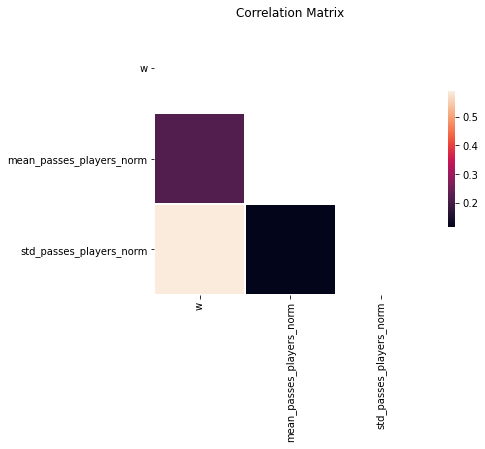

In [61]:
import seaborn as sns

corr = df.drop(columns=['avg_pass_per_game'])[['w', 'mean_passes_players_norm', 'std_passes_players_norm']].corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 5))
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
#plt.savefig('../figures/prelim_H_oct_5/correlation_matrix.png', bbox_inches='tight')
plt.show()

In [63]:
corr

,w,mean_passes_players_norm,std_passes_players_norm
w,1.000000,0.217785,0.589938
mean_passes_players_norm,0.217785,1.000000,0.117718
std_passes_players_norm,0.589938,0.117718,1.000000


In [309]:
from scipy import stats
df['H'] = stats.hmean([df['w'], df['mean_passes_players'], df['std_passes_players']])

In [310]:
df.corr()

,w,mean_passes_players,std_passes_players,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts,H
w,1.000000,0.997541,0.983159,1.000000,0.803065,0.812468,0.763279,0.992740
mean_passes_players,0.997541,1.000000,0.981636,0.997541,0.797994,0.810180,0.760530,0.992361
std_passes_players,0.983159,0.981636,1.000000,0.983159,0.778389,0.785703,0.761298,0.997650
avg_pass_per_game,1.000000,0.997541,0.983159,1.000000,0.803065,0.812468,0.763279,0.992740
avg_shots_per_game,0.803065,0.797994,0.778389,0.803065,1.000000,0.774971,0.719890,0.788817
avg_goals_per_game,0.812468,0.810180,0.785703,0.812468,0.774971,1.000000,0.873299,0.797770
end_of_season_pts,0.763279,0.760530,0.761298,0.763279,0.719890,0.873299,1.000000,0.763805
H,0.992740,0.992361,0.997650,0.992740,0.788817,0.797770,0.763805,1.000000
